In [67]:
import pandas as pd
import numpy as np

import pickle
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from umap import UMAP

## 1) import function

In [9]:
data_dict = pickle.load(open("../data/yf_basic_price_features.p",'rb'))

In [10]:
len(data_dict)

489

In [11]:
data_dict["A"].iloc[-144:, :]

,return,return_20,volatility_20,volume_daily_change,high_open,low_open,close_open
Date,,,,,,,
2020-08-13,0.011677,0.063644,0.014074,-0.096578,0.016094,0.003793,0.012506
2020-08-14,-0.014174,0.031790,0.014230,-0.196003,0.003860,0.015744,-0.010970
2020-08-17,0.001438,0.024157,0.014127,1.077815,0.010341,0.005938,-0.001638
2020-08-18,0.003589,0.019163,0.014038,0.009752,0.010234,0.006141,0.001535
2020-08-19,0.001022,0.016710,0.014026,0.409270,0.043789,0.007351,0.028667
...,...,...,...,...,...,...,...
2021-03-04,-0.036127,-0.058616,0.017895,0.689717,0.001180,0.045075,-0.031174
2021-03-05,0.010001,-0.063916,0.017626,-0.103872,0.002675,0.029427,0.002244
2021-03-08,-0.000517,-0.057639,0.017609,0.133156,0.022784,0.008942,-0.001977


In [12]:
def compute_finance_labels(df, shift=1):
    
    n = len(df.columns)
    
    df["label t"] = df["return"].apply(lambda x: 1. if x > 0 else 0.)
    df["label t+1"] = df["return"].shift(-shift).apply(lambda x: 1. if x > 0 else 0.)
    
    # removing last shift rows as there labels can not be computed
    df = df.iloc[:-shift]
    
    nr_labels = len(df.columns) - n
    
    return df, nr_labels

In [17]:
def get_data_finance(path="../data/yf_basic_price_features.p", N_train=400, T=144, scale_fin_data=StandardScaler()):
    
    data = pickle.load(open(path,'rb'))
    
    random.seed(42)
    train_companies = random.sample(list(data.keys()), N_train)
    eval_companies = [x for x in list(data.keys()) if x not in train_companies]
    
    # [16.3.] excluding BIIB for now in order to avoid nan loss
    train_companies.remove("BIIB")
    
    train_data, train_labels = [], []
    for i, comp in enumerate(train_companies):
        # print(i, comp)
        data_comp, nr_labels = compute_finance_labels(data[comp])
        
        if scale_fin_data:
            train_data_comp = scale_fin_data.fit_transform(data_comp.iloc[-T:, :-nr_labels].values)
        else:
            train_data_comp = data_comp.iloc[-T:, :-nr_labels].values
            
        train_data.append(train_data_comp)
        train_labels.append(data_comp.iloc[-T:, -nr_labels:].values)
    train_data = np.stack(train_data)
    train_labels = np.stack(train_labels)
        
    eval_data, eval_labels = [], []
    for comp in eval_companies:
        data_comp, nr_labels = compute_finance_labels(data[comp])
        
        if scale_fin_data:
            eval_data_comp = scale_fin_data.fit_transform(data_comp.iloc[-T:, :-nr_labels].values)
        else:
            eval_data_comp = data_comp.iloc[-T:, :-nr_labels].values
            
        eval_data.append(eval_data_comp)
        eval_labels.append(data_comp.iloc[-T:, -nr_labels:].values)
    eval_data = np.stack(eval_data)
    eval_labels = np.stack(eval_labels)
        
    return train_data, eval_data, train_labels, eval_labels

In [18]:
a, b, c, d = get_data_finance()

In [19]:
a.shape

(399, 144, 7)

In [20]:
b.shape

(89, 144, 7)

In [21]:
c.shape

(399, 144, 2)

In [22]:
d.shape

(89, 144, 2)

## 2) BIIB

train index 164 that was causin nan loss in VAE pretraining

In [13]:
data_dict = pickle.load(open("../data/yf_basic_price_features.p",'rb'))

In [14]:
data_dict["BIIB"].describe()

,return,return_20,volatility_20,volume_daily_change,high_open,low_open,close_open
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000
mean,0.000420,0.005424,0.022479,12.488601,0.012839,0.012509,-0.000079
std,0.028084,0.094571,0.017388,436.665403,0.019031,0.011337,0.020401
min,-0.292305,-0.333876,0.008029,-0.999882,0.000000,0.000000,-0.090742
25%,-0.009313,-0.042771,0.013748,-0.204212,0.004229,0.004715,-0.009889
50%,0.000322,0.002164,0.017294,-0.013406,0.009246,0.009812,-0.000554
75%,0.009913,0.048180,0.023058,0.237472,0.016430,0.016985,0.008541
max,0.439739,0.363922,0.122687,15420.000000,0.437283,0.099484,0.404542


In [15]:
biib = data_dict["BIIB"]
biib[biib["volume_daily_change"] == 15420.]

,return,return_20,volatility_20,volume_daily_change,high_open,low_open,close_open
Date,,,,,,,
2020-11-09,-0.281666,-0.189447,0.122386,15420.0,0.037605,0.032796,0.023568


In [16]:
data_dict["A"].describe()

,return,return_20,volatility_20,volume_daily_change,high_open,low_open,close_open
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000
mean,0.001065,0.021185,0.014832,0.082875,0.009474,0.009389,0.000196
std,0.016556,0.060478,0.007571,0.481122,0.009021,0.009239,0.012717
min,-0.110117,-0.257638,0.005181,-0.694553,0.000000,0.000000,-0.051347
25%,-0.005798,-0.015190,0.010369,-0.210729,0.003644,0.003144,-0.006376
50%,0.001528,0.026560,0.013151,-0.018878,0.007199,0.006610,0.000362
75%,0.009132,0.060964,0.016427,0.255337,0.012423,0.012609,0.007234
max,0.098394,0.238243,0.059881,4.678461,0.075921,0.070509,0.066950


## 3) normalization / standardization

- https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf#:~:text=Normalization%20typically%20means%20rescales%20the,of%201%20(unit%20variance).

- https://www.youtube.com/watch?v=Xjtu1L7RwVM&list=PLoRl3Ht4JOcdU872GhiYWf6jwrk_SNhz9&index=27
- https://datascience.stackexchange.com/questions/43206/financial-time-series-data-normalization
- https://www.researchgate.net/profile/Gisele-Pappa/publication/221532708_Adaptive_Normalization_A_novel_data_normalization_approach_for_non-stationary_time_series/links/0c96051cc596087da6000000/Adaptive-Normalization-A-novel-data-normalization-approach-for-non-stationary-time-series.pdf
- https://arxiv.org/pdf/1902.07892.pdf

In [18]:
data_dict["A"]

,return,return_20,volatility_20,volume_daily_change,high_open,low_open,close_open
Date,,,,,,,
2016-03-29,0.016195,0.075235,0.016423,-0.142610,0.022109,0.006099,0.020585
2016-03-30,-0.000996,0.039647,0.014907,-0.282075,0.005451,0.011645,-0.005947
2016-03-31,-0.006730,0.020748,0.014850,3.012637,0.002249,0.008748,-0.003999
2016-04-01,0.014471,0.031292,0.015137,-0.090886,0.020728,0.001517,0.018959
2016-04-04,-0.007443,0.019974,0.015264,0.035097,0.004960,0.012897,-0.007689
...,...,...,...,...,...,...,...
2021-03-04,-0.036127,-0.058616,0.017895,0.689717,0.001180,0.045075,-0.031174
2021-03-05,0.010001,-0.063916,0.017626,-0.103872,0.002675,0.029427,0.002244
2021-03-08,-0.000517,-0.057639,0.017609,0.133156,0.022784,0.008942,-0.001977


In [91]:
def plot_scalers(df, scalers):
    
    
    
    for scaler in scalers:
        
        fig, axs = plt.subplots(len(df.columns), 2, figsize=(15, 5 * len(df.columns)))
        
        df_trans = scaler.fit_transform(df)
        
        print("=================================== {} ====================================".format(str(scaler)))
        
        for i, col_ in enumerate(df.columns):
            
            axs[i, 0].plot(df[col_].values)
            axs[i, 0].set_title(col_)
            
            axs[i, 1].plot(df_trans[:, i])
            axs[i, 1].set_title("scaled {}".format(col_))
            
        plt.show()

=================================== StandardScaler() ====================================


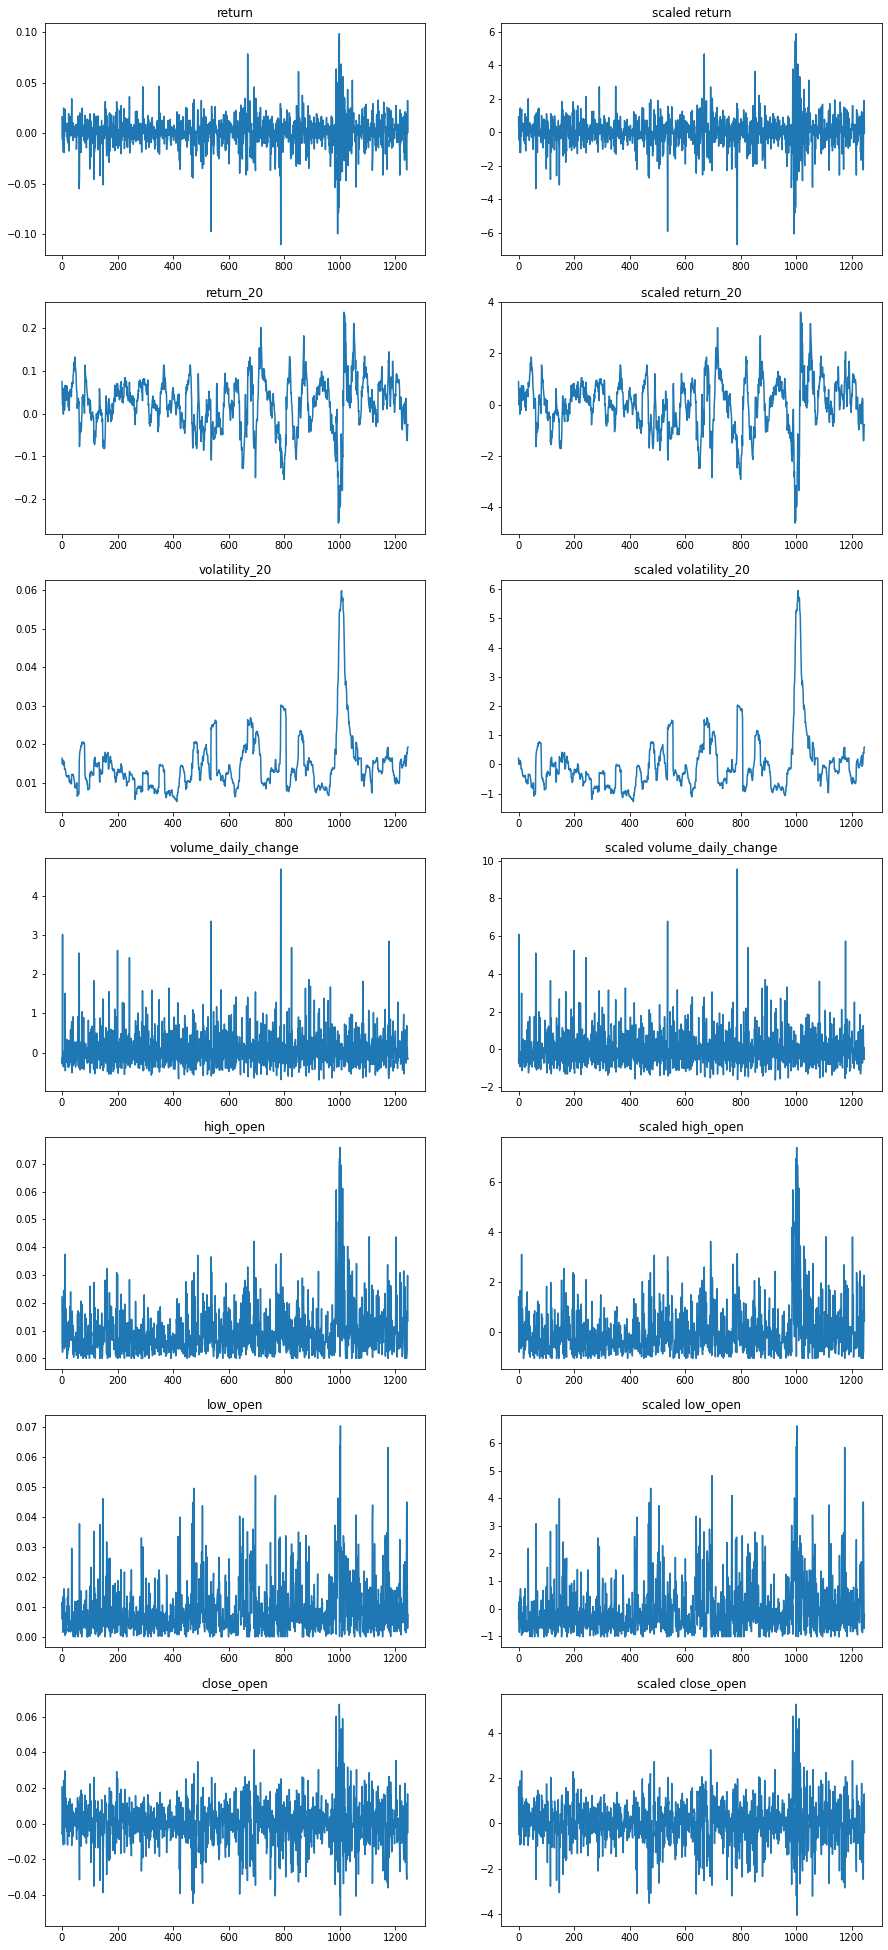

=================================== RobustScaler() ====================================


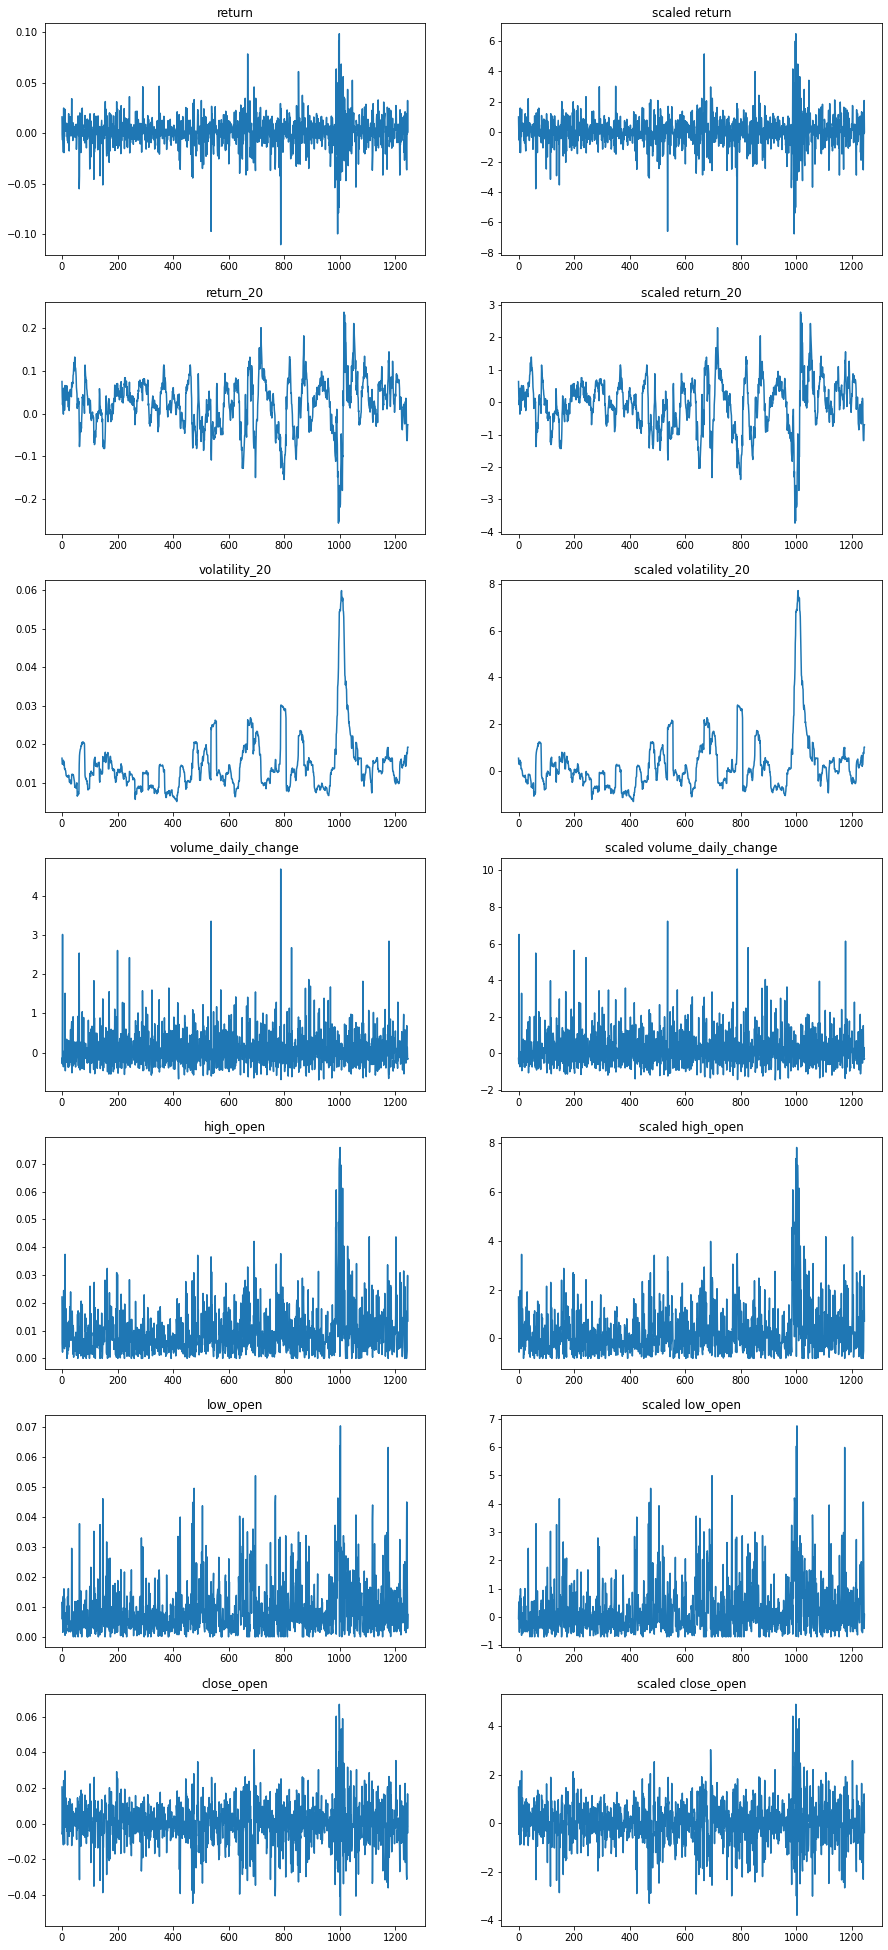

=================================== MinMaxScaler() ====================================


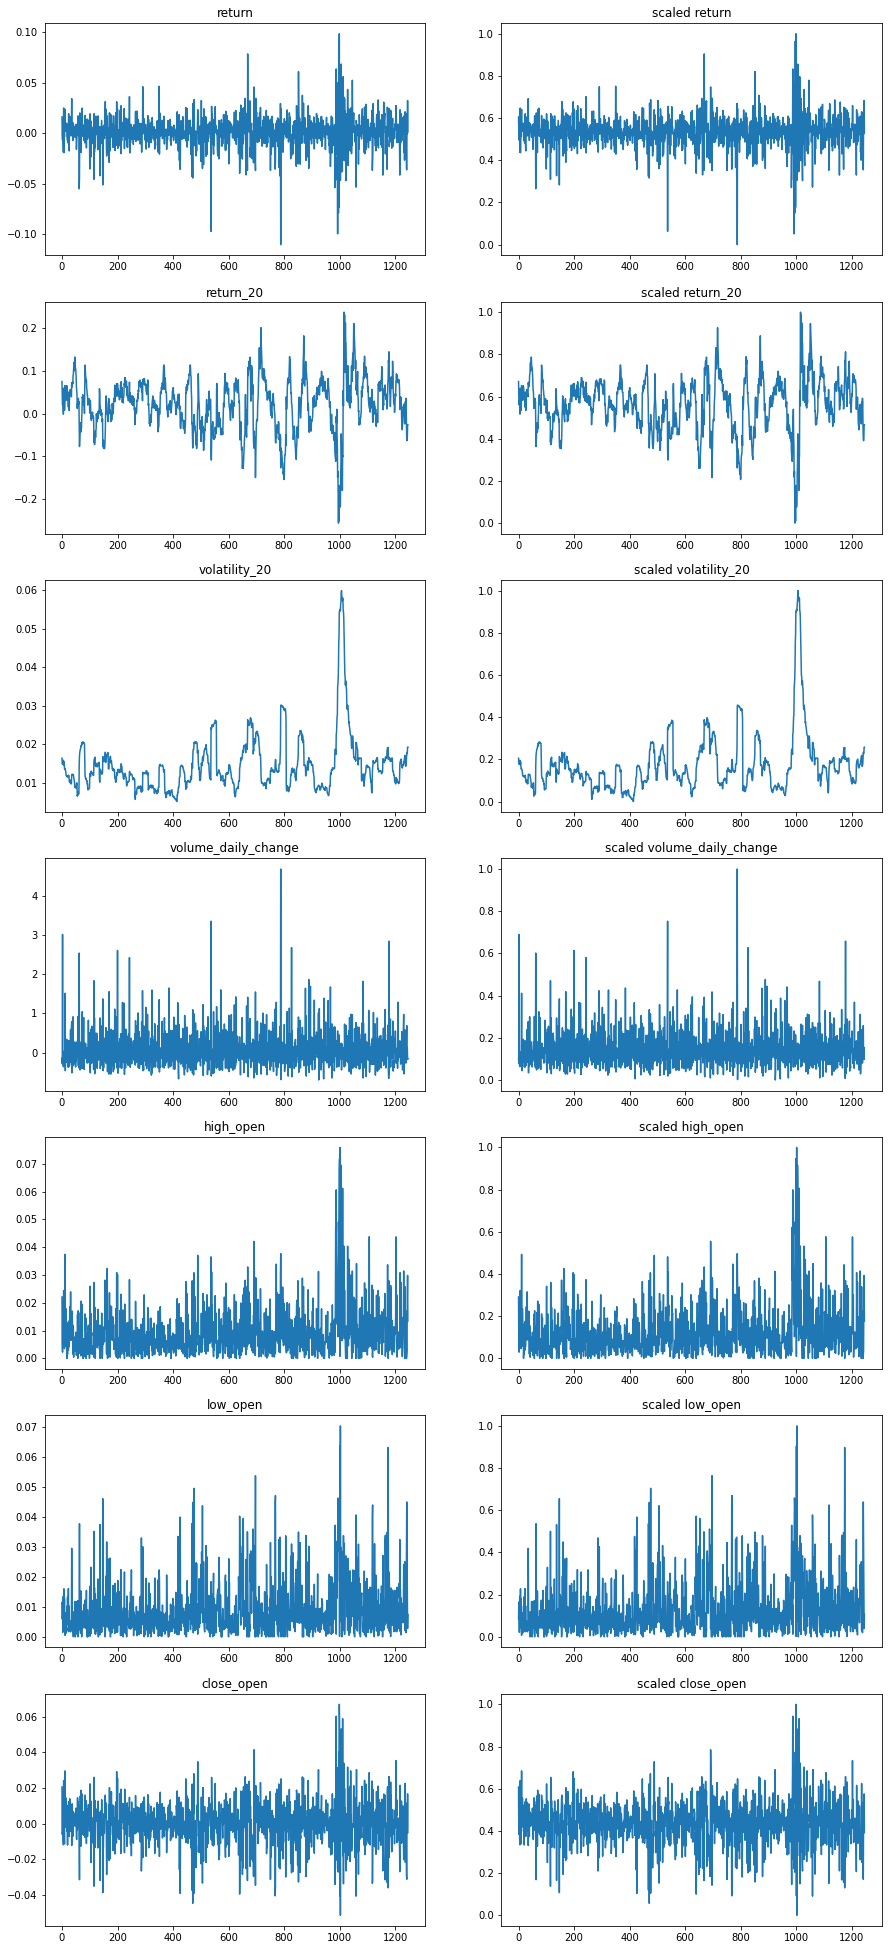

In [92]:
plot_scalers(data_dict["A"], [StandardScaler(), RobustScaler(), MinMaxScaler()])

In [28]:
data_dict["A"].mean(axis=0)

return                 0.001065
return_20              0.021185
volatility_20          0.014832
volume_daily_change    0.082875
high_open              0.009474
low_open               0.009389
close_open             0.000196
dtype: float64

In [33]:
trans = RobustScaler().fit_transform(data_dict["A"])
trans_standard = StandardScaler().fit_transform(data_dict["A"])
trans_object = StandardScaler().fit(data_dict["A"])

In [27]:
trans.mean(axis=0)

array([-0.03095604, -0.07057451,  0.27749197,  0.2183239 ,  0.25923164,
        0.29361986, -0.01215152])

In [29]:
trans_standard.mean(axis=0)

array([-9.25927783e-18, -5.69801713e-17,  2.50712754e-16, -6.87323316e-17,
        1.13960343e-17,  3.41881028e-17, -4.27351285e-18])

In [30]:
trans_standard.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

<AxesSubplot:xlabel='Date'>

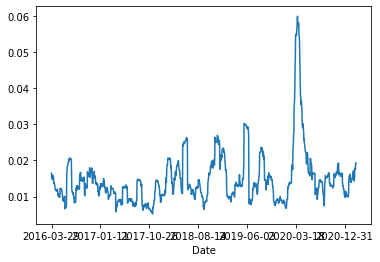

In [53]:
data_dict["A"]["volatility_20"].plot()

In [44]:
data_dict["A"]["return"].values

array([ 0.01619464, -0.00099635, -0.00672972, ..., -0.0005166 ,
        0.03239141,  0.00125168])

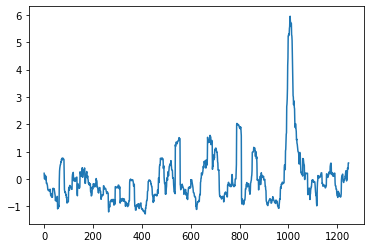

In [52]:
plt.plot(StandardScaler().fit_transform(np.reshape(data_dict["A"]["volatility_20"].values, (-1, 1))))

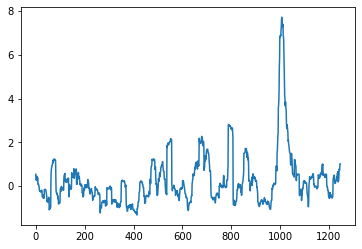

In [54]:
plt.plot(RobustScaler().fit_transform(np.reshape(data_dict["A"]["volatility_20"].values, (-1, 1))))

## 3) t-SNE and umap plots

In [64]:
def plot_latents_angles_digits(z_emb, aux_data, save_path=None, subsample=None):
    """
    
    """
    
    if subsample:
        ind = np.random.randint(z_emb.shape[0], size=int(len(z_emb)*subsample))
        z_emb = z_emb[ind, :].copy()
        aux_data = aux_data[ind, :].copy()

    # assign color to each latent embedding
    color_dict = {0: 'blue', 1: 'red'}
    colors_return = [color_dict[x] for x in aux_data[:,0]]
    colors_next_return = [color_dict[x] for x in aux_data[:,1]]
    
    # plot
    if z_emb.shape[1] == 2:
        fig, ax = plt.subplots(2, 1, figsize=(10,12))
        ax[0].scatter(z_emb[:,0], z_emb[:,1], color=colors_return)
        markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
        ax[0].legend(markers, color_dict.keys(), numpoints=1, bbox_to_anchor=(1., 1.05), title="Return day t")
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].scatter(z_emb[:,0], z_emb[:,1], color=colors_next_return)
        markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
        ax[1].legend(markers, color_dict.keys(), numpoints=1, bbox_to_anchor=(1., 1.05), title="Return day t + 1")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        
    elif z_emb.shape[1] == 3:
        fig = plt.figure(figsize=(10,10))
        ax = Axes3D(fig)
        ax.scatter(z_emb[:,0], z_emb[:,1], z_emb[:,2], color=colors_return)
        # markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
        # ax[0].legend(markers, color_dict.keys(), numpoints=1, bbox_to_anchor=(1., 1.05), title="Return day t")
        # ax[0].set_xticks([])
        # ax[0].set_yticks([])
        # ax[0].set_zticks([])
        plt.show()

        fig = plt.figure(figsize=(10,10))
        ax = Axes3D(fig)
        ax.scatter(z_emb[:,0], z_emb[:,1], z_emb[:,2], color=colors_next_return)
        # markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
        # ax[1].legend(markers, color_dict.keys(), numpoints=1, bbox_to_anchor=(1., 1.05), title="Return day t + 1")
        # ax[1].set_xticks([])
        # ax[1].set_yticks([])
        # ax[1].set_zticks([])
        plt.show()
        
    if save_path:
        plt.savefig(save_path, format="pdf")
    plt.show()

### 3.1) t-SNE

In [23]:
a, b, c, d = get_data_finance()
a = np.reshape(a, (-1, 7))

In [27]:
a_2d = TSNE(n_components=2).fit_transform(a)

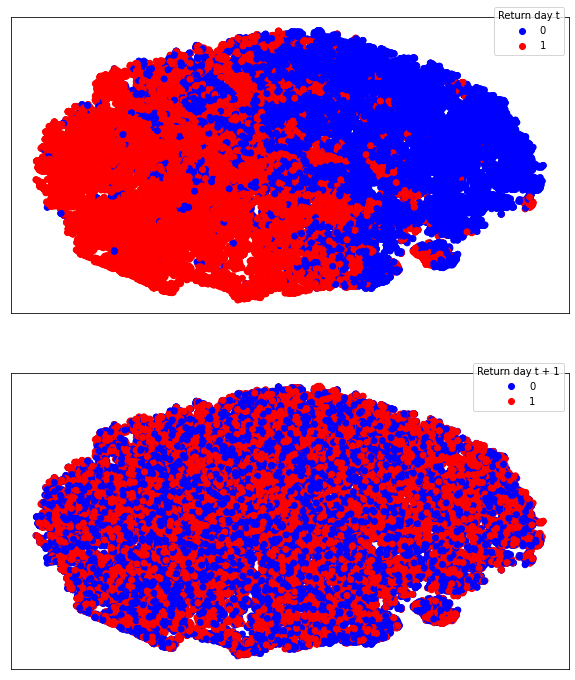

In [41]:
plot_latents_angles_digits(a_2d, np.reshape(c, (-1, 2)))

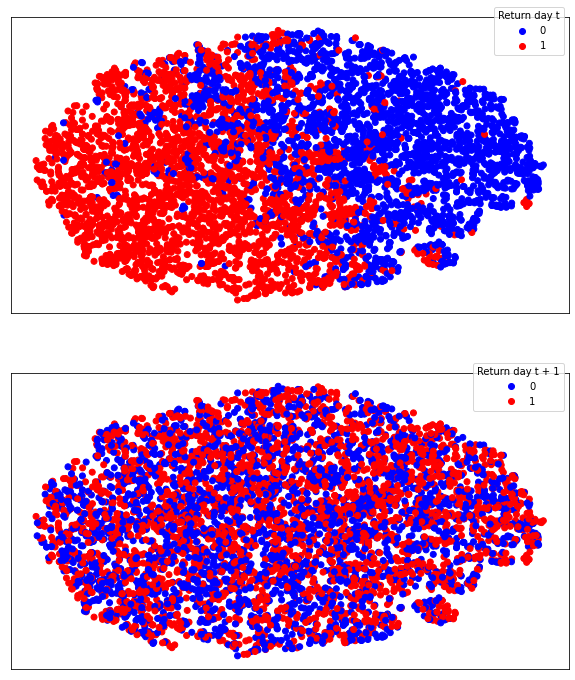

In [47]:
plot_latents_angles_digits(a_2d, np.reshape(c, (-1, 2)), subsample=0.1)

In [49]:
a_3d = TSNE(n_components=3).fit_transform(a)

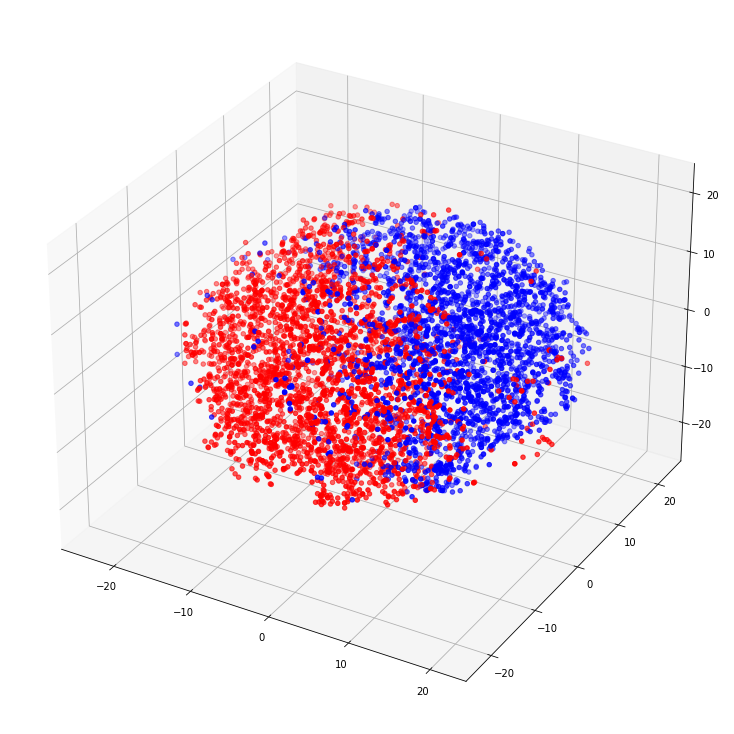

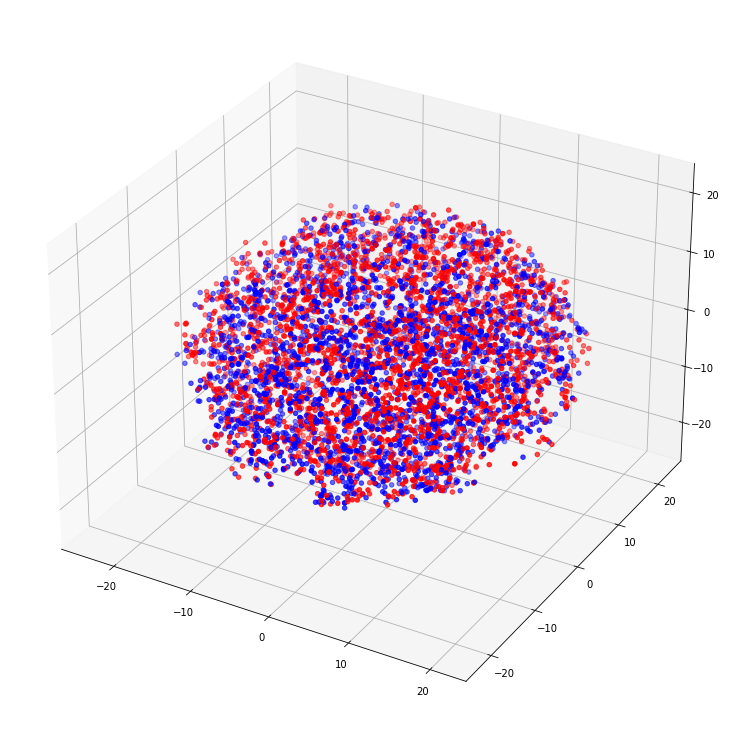

In [65]:
plot_latents_angles_digits(a_3d, np.reshape(c, (-1, 2)), subsample=0.1)

### 3.2) umap

In [68]:
a_2d_umap = UMAP(n_components=2).fit_transform(a)

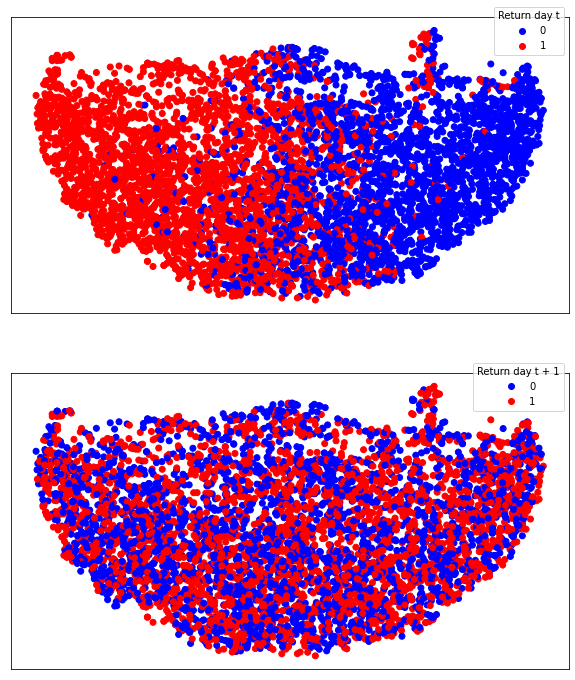

In [69]:
plot_latents_angles_digits(a_2d_umap, np.reshape(c, (-1, 2)), subsample=0.1)

In [70]:
a_3d_umap = UMAP(n_components=3).fit_transform(a)

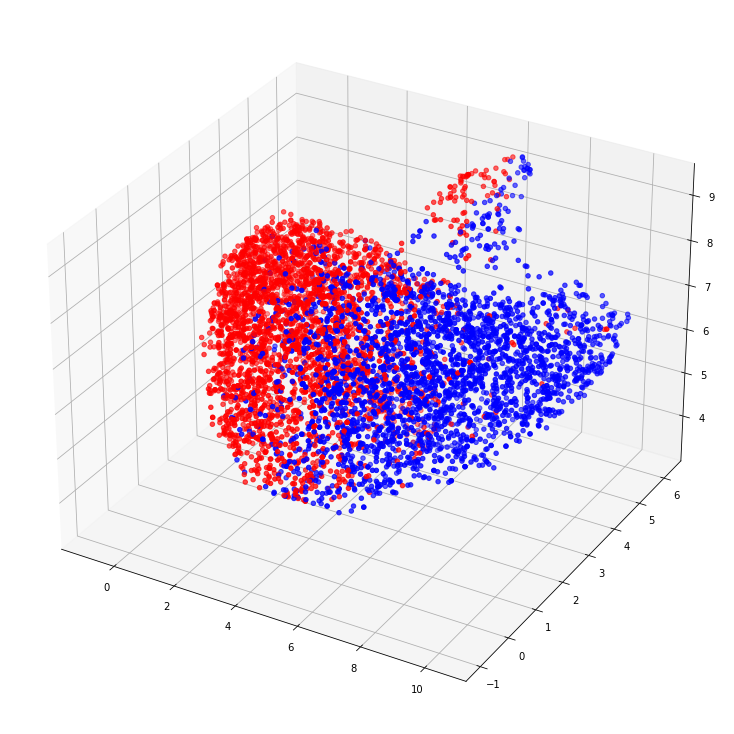

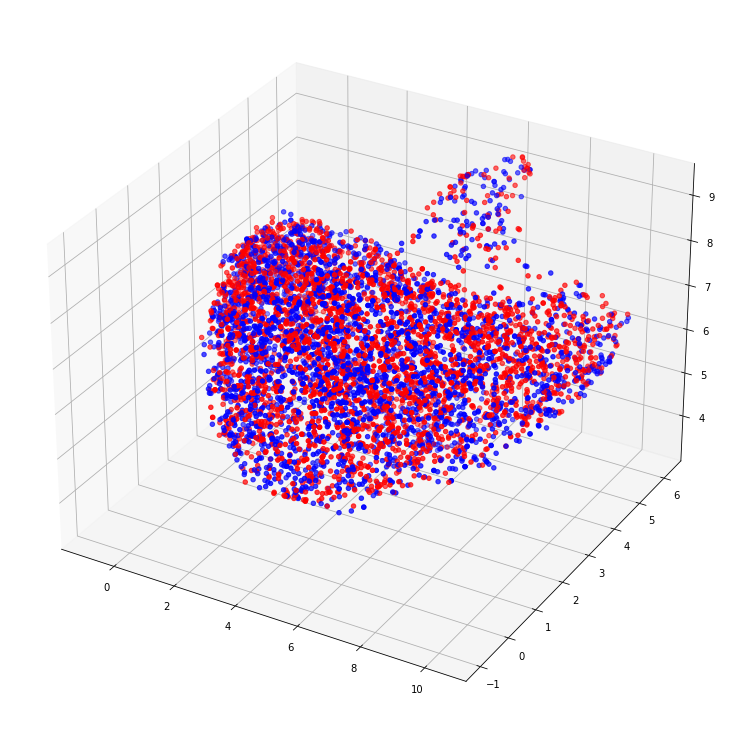

In [71]:
plot_latents_angles_digits(a_3d_umap, np.reshape(c, (-1, 2)), subsample=0.1)